### Load dataset and rename columns
> Note: **Only AMST** are contained in df. HNK products where filtered.

In [1]:
import pandas as pd
import numpy as np
from re import sub

def column_name_to_snake_case(s):
    # change chars for undescore
    s = sub(r"[\/( \- ) ]", '_', s)
    # make undescores unique
    s = sub(r"(___)|(__)", '_', s).lower()
    return s if s[-1] != '_' else s[:-1]

df = pd.read_csv(r'..\data\1_raw\Heineken - Data Science Use Case.csv', parse_dates=['Date/Time'])
df = (df.drop(columns=df.columns[0]) # drop csv index
        .rename(columns={col:column_name_to_snake_case(col) for col in df.columns[1:]})        
     )
print('original len:', len(df))
# saving hnk values to data folder
not_amst = df.query('product != "AMST"')
not_amst.to_csv('../data/2_dropped/not_amst.csv', index=False)

# selecting only amst batches
df = df.query('product == "AMST"')
print(len(df))


original len: 200
180


### Rows with null values

In [2]:
nulls = df[pd.isnull(df).any(axis=1)]
print('len nulls:', len(nulls))


len nulls: 38


#### Analyzing target (color) null values
All color null values have no other null value besides the target column.
> Note: try to predict these values later

In [3]:
# only null that are target 
target_nulls = nulls.query('color.isnull()')
print(target_nulls.drop('color', axis=1).isnull().sum(axis=0))

# saving to parse dtypes faster later 
dtypes = {col:target_nulls[col].dtype for col in target_nulls.columns}

target_nulls.to_csv(r'..\data\2_dropped\dropped_rows.csv', index=False)



job_id                0
date_time             0
roast_amount_kg       0
1st_malt_amount_kg    0
2nd_malt_amount_kg    0
mt_temperature        0
mt_time               0
wk_temperature        0
wk_steam              0
wk_time               0
total_cold_wort       0
ph                    0
extract               0
woc_time              0
whp_transfer_time     0
whp_rest_time         0
roast_color           0
1st_malt_color        0
2nd_malt_color        0
product               0
dtype: int64


#### Check non_target nulls
Null values from other column correspond to small percentage of total count of row count.

We will use interpolation with KNN to estimate missing values.

In [4]:
non_target = nulls.query('color.notnull()')
print('non_target nulls len:', len(non_target), '\n')

non_target = (non_target.drop('color', axis=1)
                        .isnull().sum(axis=0)[lambda x: x >0]
                        .to_frame('null_count'))

non_target = (non_target.assign(len_df = len(df))
                        .assign(ratio= non_target.null_count/len(df)))

print(non_target)


# using interpolation to fill NAs on roast amount and ph
df = df.assign(**{col:df[col].interpolate(method='nearest') for col in ['roast_amount_kg', 'ph']})
print('\n\nnull values after interpolation')
pd.isnull(df).sum()[lambda x: x > 0]
non_target

non_target nulls len: 8 

                 null_count  len_df     ratio
roast_amount_kg           3     180  0.016667
ph                        5     180  0.027778




null values after interpolation


,null_count,len_df,ratio
roast_amount_kg,3,180,0.016667
ph,5,180,0.027778


### Selected data

In [5]:
import seaborn as sns
selected = (df.select_dtypes(include='number')
              .dropna()
             )
selected_cols = selected.columns
selected.describe()


,job_id,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,color,woc_time,whp_transfer_time,whp_rest_time,roast_color,1st_malt_color,2nd_malt_color
count,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000,150.000000,150.000000
mean,2.449966e+09,40.364099,13708.801941,6518.586737,67.819929,6755.558000,105.240010,6715.525000,6776.986333,936.898333,5.622935,15.202680,17.741587,3101.783500,752.844000,14.495181,908.375,6.048667,6.019283
std,2.924662e+03,17.982047,1369.917810,1102.770677,2.861199,440.785944,0.636487,279.615828,588.860492,134.627923,0.744504,1.017336,9.645823,548.827876,59.693521,0.007603,0.000,0.081353,0.015237
min,2.449960e+09,17.415013,0.000000,3996.957605,66.866813,6458.600000,97.659771,6170.500000,5929.700000,68.800000,2.295564,6.796530,11.542656,107.500000,719.175000,14.476667,908.375,5.912500,5.912500
25%,2.449963e+09,24.778737,13944.859845,6068.565933,66.909513,6620.387500,105.202896,6568.250000,6554.275000,954.600000,5.547247,15.148521,12.892941,3123.950000,729.925000,14.494583,908.375,6.020000,6.020000
50%,2.449966e+09,28.272487,14041.300940,6074.067303,67.002759,6700.475000,105.269124,6654.250000,6665.000000,963.200000,5.625450,15.391154,13.418677,3143.837500,736.375000,14.494583,908.375,6.020000,6.020000
75%,2.449968e+09,64.177513,14087.302593,6160.225824,67.208414,6773.575000,105.373703,6802.062500,6807.437500,968.575000,5.743791,15.551699,14.864908,3171.250000,743.900000,14.494583,908.375,6.127500,6.020000
max,2.449971e+09,88.042526,16092.750000,8434.826355,81.452861,11671.275000,105.718793,8202.250000,12621.575000,1088.975000,7.382991,16.320075,44.990000,4876.200000,1241.625000,14.584167,908.375,6.127500,6.127500


### Check normality of features and target
All features were found to be normally distributed besides roast color


array([[<Axes: title={'center': 'roast_amount_kg'}>,
        <Axes: title={'center': '1st_malt_amount_kg'}>,
        <Axes: title={'center': '2nd_malt_amount_kg'}>,
        <Axes: title={'center': 'mt_temperature'}>],
       [<Axes: title={'center': 'mt_time'}>,
        <Axes: title={'center': 'wk_temperature'}>,
        <Axes: title={'center': 'wk_steam'}>,
        <Axes: title={'center': 'wk_time'}>],
       [<Axes: title={'center': 'total_cold_wort'}>,
        <Axes: title={'center': 'ph'}>,
        <Axes: title={'center': 'extract'}>,
        <Axes: title={'center': 'woc_time'}>],
       [<Axes: title={'center': 'whp_transfer_time'}>,
        <Axes: title={'center': 'whp_rest_time'}>,
        <Axes: title={'center': 'roast_color'}>,
        <Axes: title={'center': '1st_malt_color'}>],
       [<Axes: title={'center': '2nd_malt_color'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

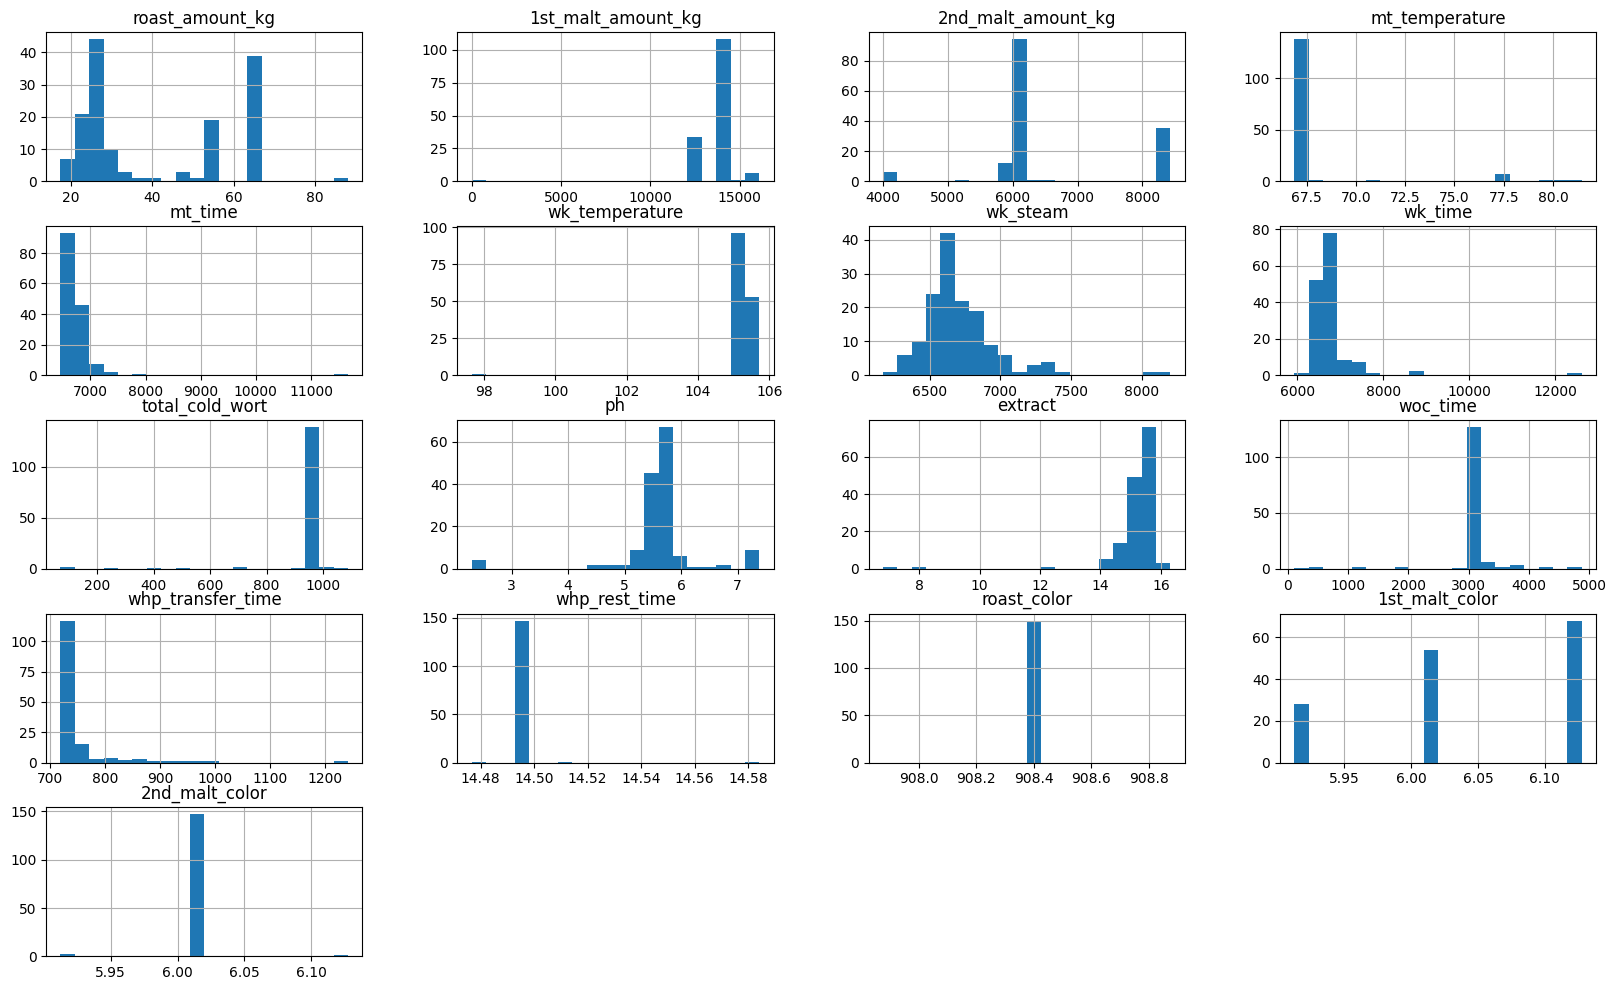

In [6]:
selected.drop(columns=['job_id','color']).hist(bins=20, figsize=(20,12))

In [18]:
from scipy.stats import shapiro, kstest

print('len features:', len(selected))
def check_normality(df:pd.DataFrame, columns:list[str]):
    shapiro_p_value = [shapiro(df[col].values).pvalue for col in columns]
    kstest_p_value = [kstest(df[col].values, 'norm').pvalue for col in columns]

    normality_tests = pd.DataFrame(
        {'columns': columns, 'shapiro_p_value': shapiro_p_value, 'kstest_p_value': kstest_p_value})

    normality_tests['failed'] = normality_tests.apply(lambda row: 'yes' if row['shapiro_p_value'] > 0.05 or row['kstest_p_value'] > 0.05 else 'no', axis=1)
    return normality_tests
n = check_normality(selected, selected_cols)
n.query('columns != "job_id"').style.background_gradient(subset=['shapiro_p_value', 'kstest_p_value'], vmin=0, vmax=1, cmap='Greens')


len features: 150


c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,columns,shapiro_p_value,kstest_p_value,failed
1,roast_amount_kg,0.000000,0.000000,no
2,1st_malt_amount_kg,0.000000,0.000000,no
3,2nd_malt_amount_kg,0.000000,0.000000,no
4,mt_temperature,0.000000,0.000000,no
5,mt_time,0.000000,0.000000,no
6,wk_temperature,0.000000,0.000000,no
7,wk_steam,0.000000,0.000000,no
8,wk_time,0.000000,0.000000,no
9,total_cold_wort,0.000000,0.000000,no
10,ph,0.000000,0.000000,no


> note: roast color is constant, so it will be dropped

In [ ]:
selected = selected.drop(columns='roast_color')
selected.to_csv('../data/3_selected/selected.csv', index=False)

#### Check normality of target
> note: use median for baseline model

In [ ]:

target_normality = check_normality(selected, ['color'])
target_normality


,columns,shapiro_p_value,kstest_p_value,failed
0,color,5.284953e-19,0.0,no


checking how null values are positioned in timeline

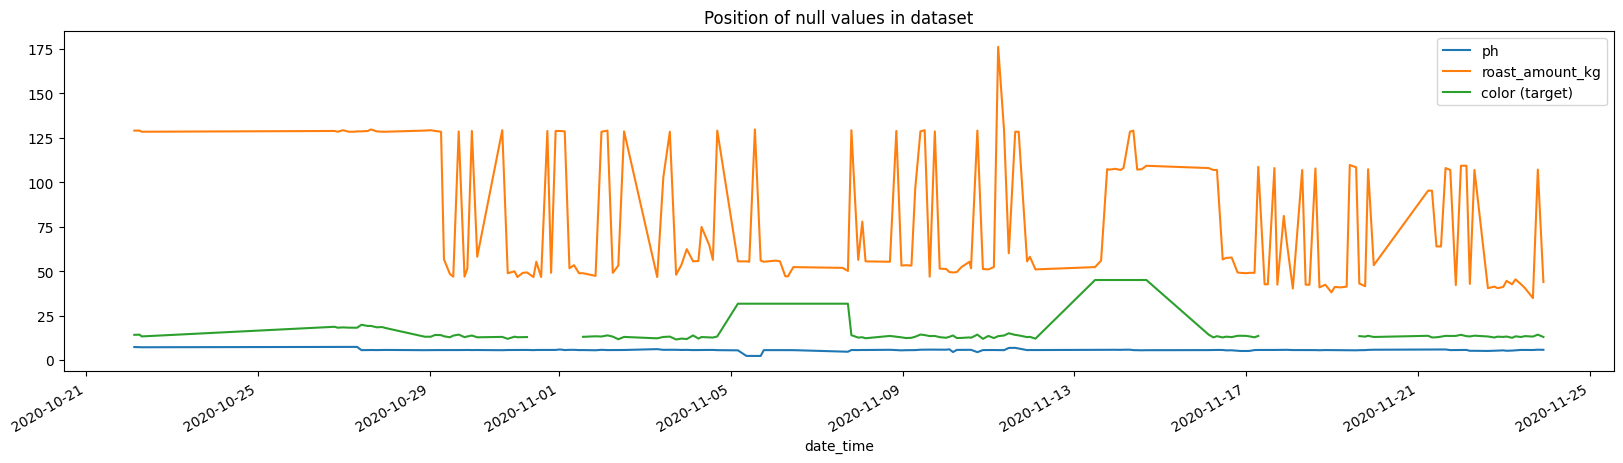

In [ ]:
df['base_amount_kg'] = df['1st_malt_amount_kg'] + df['2nd_malt_amount_kg']
# Multiplied by 2 just offset lines a little bit
df.roast_amount_kg = df.roast_amount_kg*2
df['color (target)'] = df.color

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
ax = df.sort_values('date_time').reset_index().plot(x='date_time', y=['ph', 'roast_amount_kg', 'color (target)'])
ax.set(title='Position of null values in dataset')

# undo changes to dataset
df.roast_amount_kg = df.roast_amount_kg/2

### Target box plot


[Text(0.5, 1.0, 'Target box plot')]

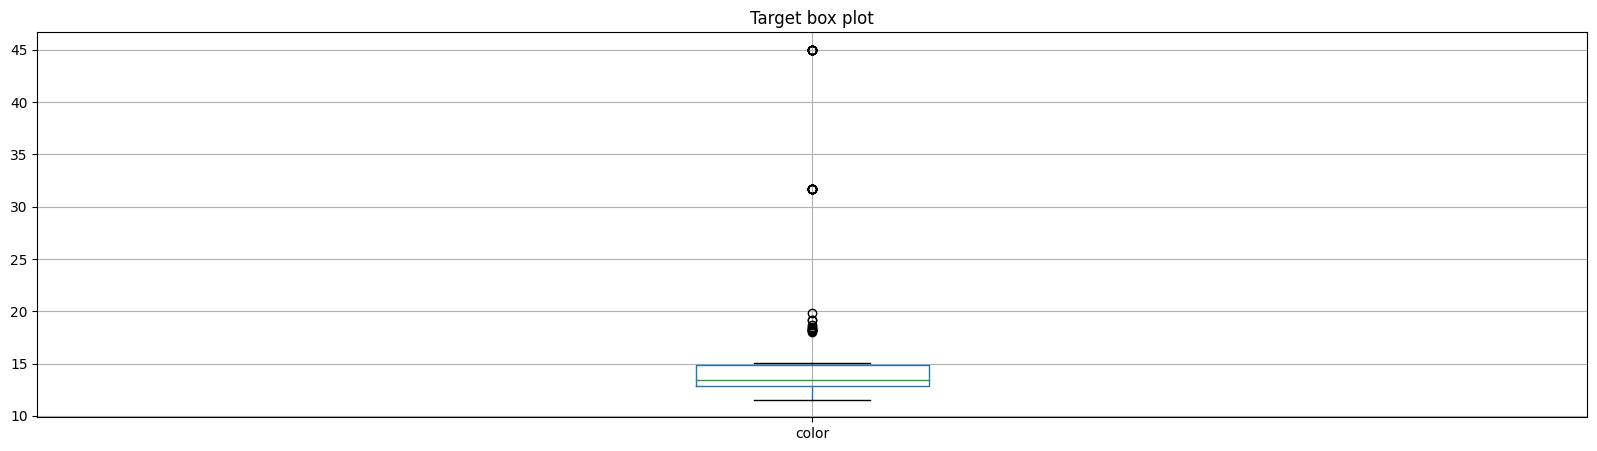

In [ ]:
ax = df[['color']].boxplot()
ax.set(title='Target box plot')

### Outlier Detection
> note: check performance with and without outliers

In [ ]:
from scipy import stats


#apply the z-score method and get abs 
z_scores = np.abs(stats.zscore(selected))


threshold = 3
outliers = selected[z_scores > threshold]
print(f'{len(outliers[outliers.notnull().any(axis=1)])} rows contain at least one outlier')
outliers = outliers[outliers.notnull().any(axis=1)]
print('Outlier ratio:', f'{len(outliers)/len(selected):.2%}')
outliers

31 rows contain at least one outlier
Outlier ratio: 20.67%


,job_id,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,color,woc_time,whp_transfer_time,whp_rest_time,1st_malt_color,2nd_malt_color
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4866.525,NaN,14.584167,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1241.625,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,983.625,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,77.369326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1275
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,965.350,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9125
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9125
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8202.25,NaN,NaN,NaN,NaN,NaN,NaN,936.325,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.310204,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Correlation plots

<Axes: title={'center': 'Pearson Correlation plot'}>

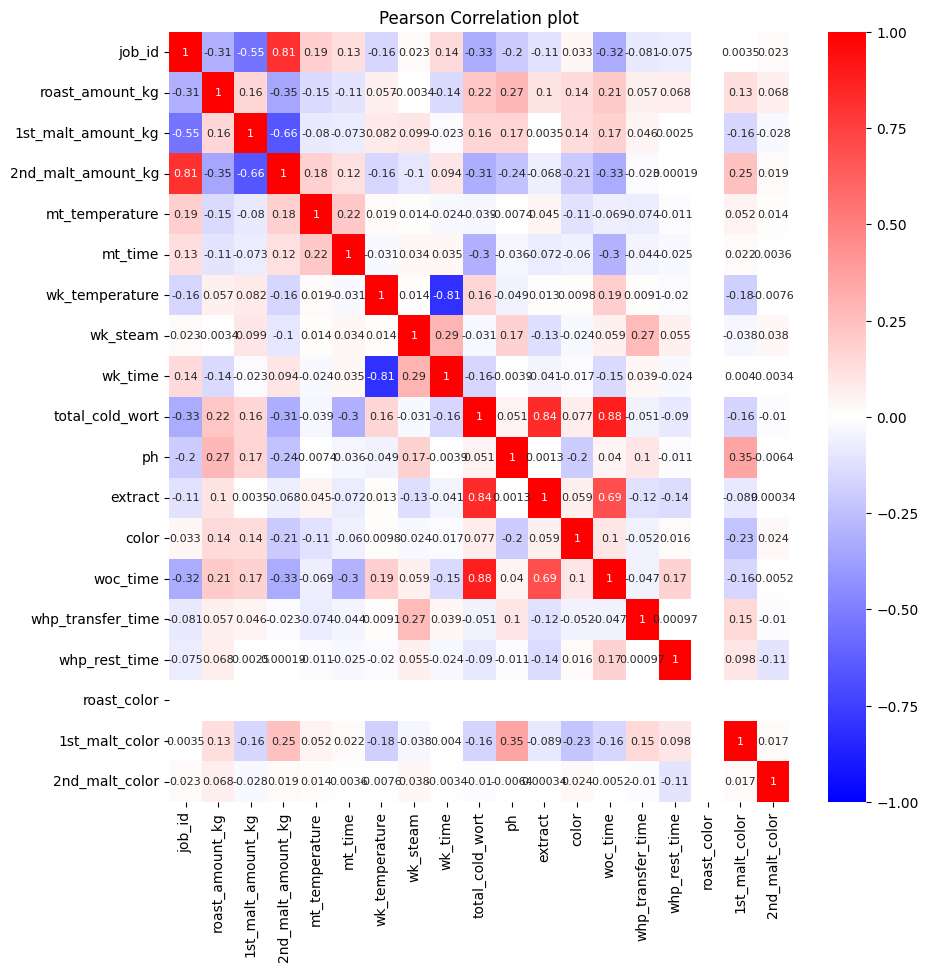

In [ ]:
from typing import Literal
import matplotlib.pyplot as plt
def correlation_level(x): 
    corr = abs(x)
    if corr < 0.1: return 'None'
    if corr >= 0.1 and corr < 0.3: return 'Weak'
    if corr >= 0.3 and corr < 0.6: return 'Moderate'
    if corr >= 0.6 and corr < 0.95: return 'Strong'
    if x >= 0.95: return 'Perfect'
    return 'None'

def map_correlation_levels(x, cmap='Dark2'):
    levels = ['None', 'Weak', 'Moderate', 'Strong', 'Perfect']
    colors = [getattr(plt.cm, cmap)(i) for i in range(len(levels)-1)]
    map = dict(zip(levels, colors))
    return map.get(x, colors[0])

def plot_correlation_heatmap(df:pd.DataFrame, corr_method:Literal['pearson', 'spearman', 'kendall']):
    plt.rcParams["figure.figsize"] = (10,10)
    
    corr_df = df.dropna().corr(corr_method)
    ax = sns.heatmap(corr_df, 
                    vmin=-1, vmax=1, center=0, 
                    cmap='bwr', annot=corr_df.values,annot_kws={'fontsize':8})
    ax.set(title=f'{corr_method.title()} Correlation plot')
    return ax

def plot_correlation_bars(df:pd.DataFrame, column:str,  corr_method:Literal['pearson', 'spearman', 'kendall']):
    # absolute correlation 
    corr_df = df.dropna().corr(corr_method)
    plt.rcParams["figure.figsize"] = (20,5)
    corr_abs = (corr_df[[column]].assign(abs=corr_df[column].abs())
                                 .assign(category=corr_df[column].apply(lambda x: correlation_level(x)))
                                 .sort_values('abs', ascending=False)
                                 .reset_index(names=['columns'])
                                 .query(f'columns != "{column}"'))
    fig, ax = plt.subplots()
    from matplotlib.patches import Patch
    color = dict(zip(corr_abs.category.unique(), [map_correlation_levels(x) for x in corr_abs.category.unique()]))
    (corr_abs.plot.bar(x='columns', y=column, color=[map_correlation_levels(x) for x in corr_abs.category.values], ax=ax)
                  .legend([Patch(facecolor=color[i])for i in color], color))
    
    ax.set(title=f'{corr_method.title()} Correlation with {column} by column')
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i-0.2,y[i]+0.005 if y[i] > 0 else 0.005,y[i])
    addlabels(corr_abs.index, [float('%.3f'%x) for x in corr_abs[column].values])

    return ax

plot_correlation_heatmap(df[selected_cols], 'pearson')


<Axes: title={'center': 'Pearson Correlation with color by column'}, xlabel='columns'>

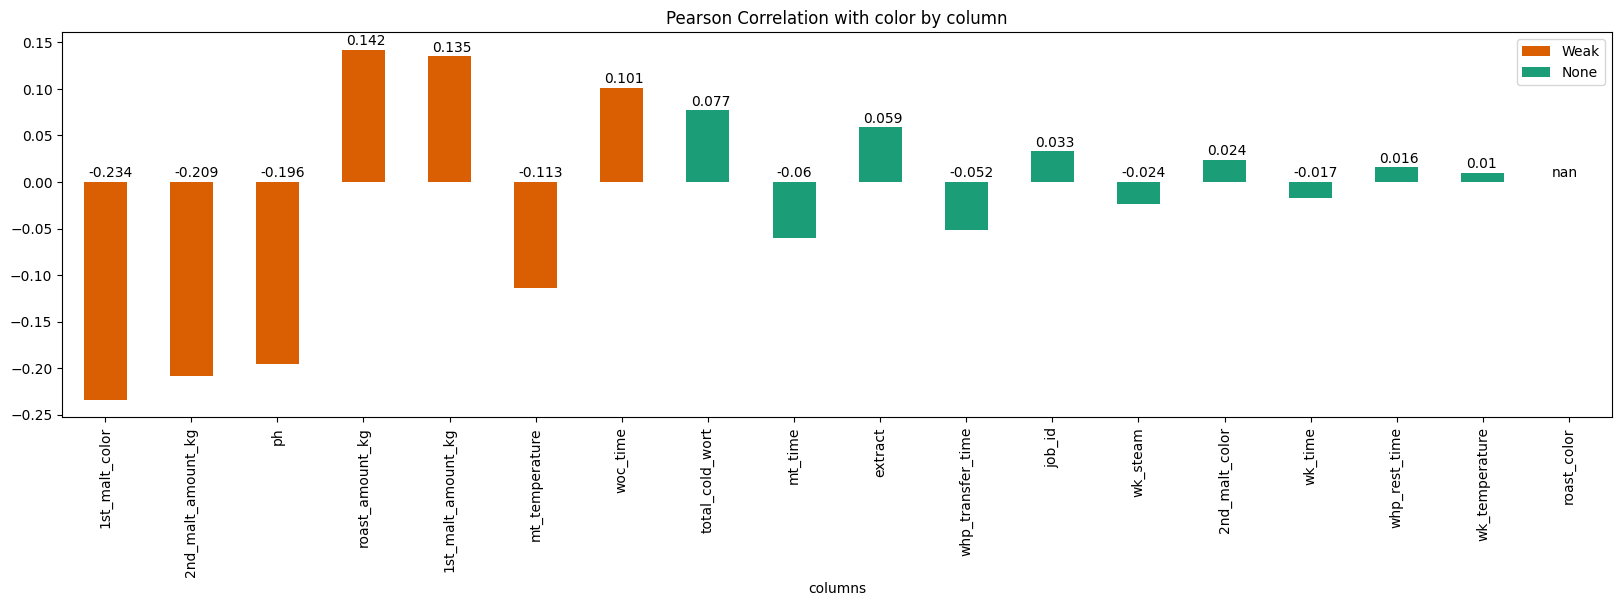

In [ ]:
plot_correlation_bars(df[selected_cols], 'color', 'pearson')

<Axes: title={'center': 'Pearson Correlation with total_cold_wort by column'}, xlabel='columns'>

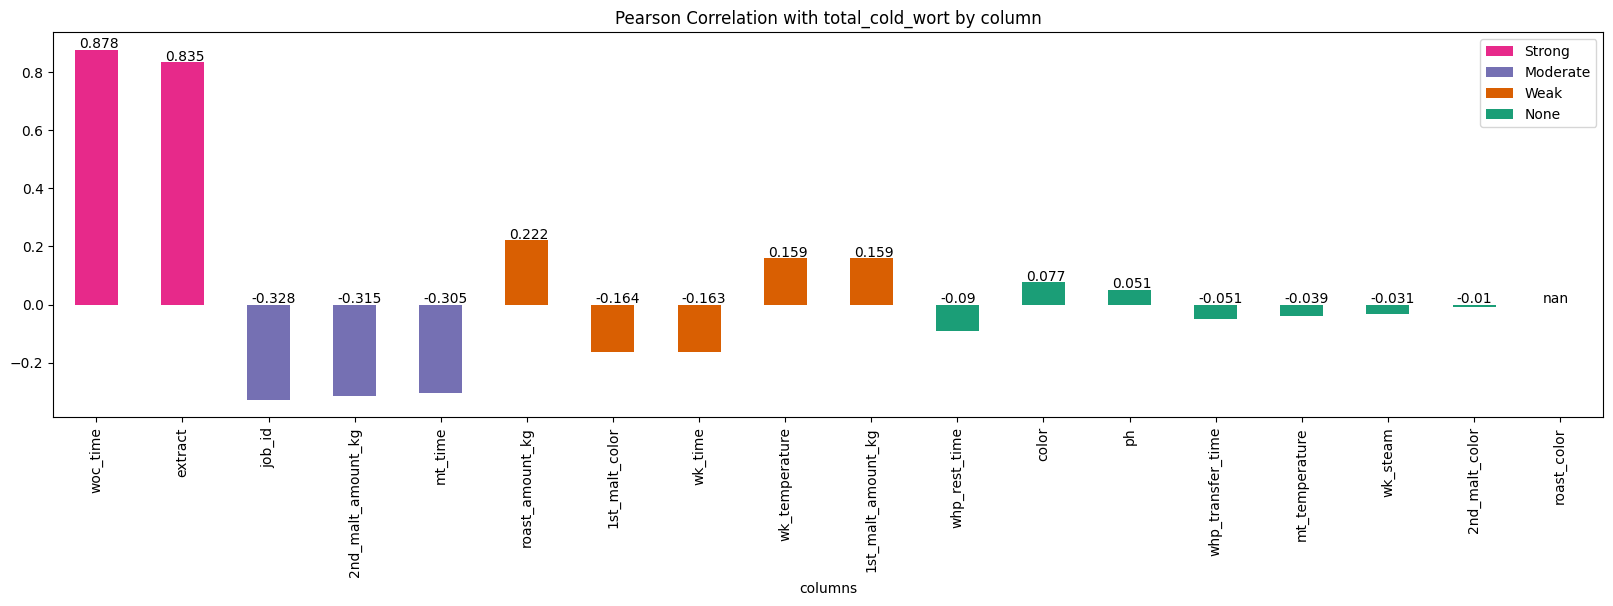

In [ ]:
plot_correlation_bars(df[selected_cols], 'total_cold_wort', 'pearson')

<Axes: title={'center': 'Pearson Correlation with wk_time by column'}, xlabel='columns'>

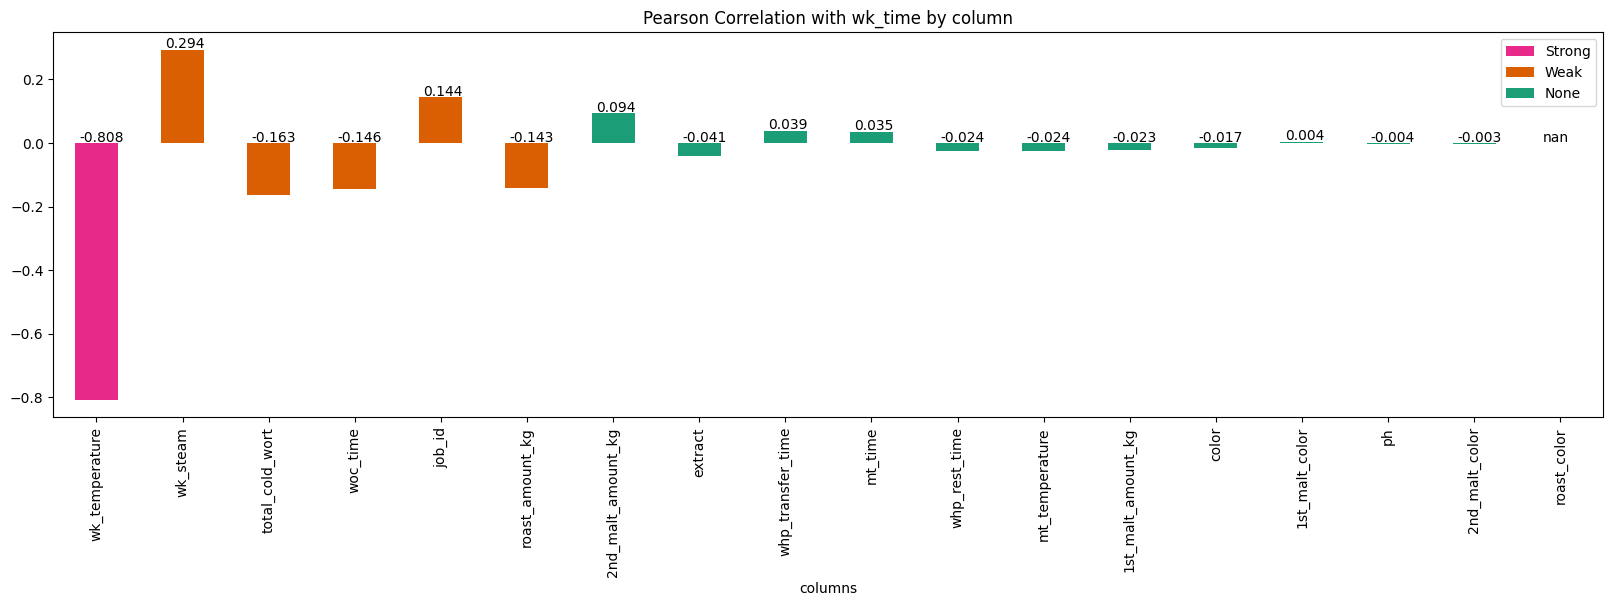

In [ ]:
plot_correlation_bars(df[selected_cols], 'wk_time', 'pearson')

<Axes: title={'center': 'Pearson Correlation with 1st_malt_amount_kg by column'}, xlabel='columns'>

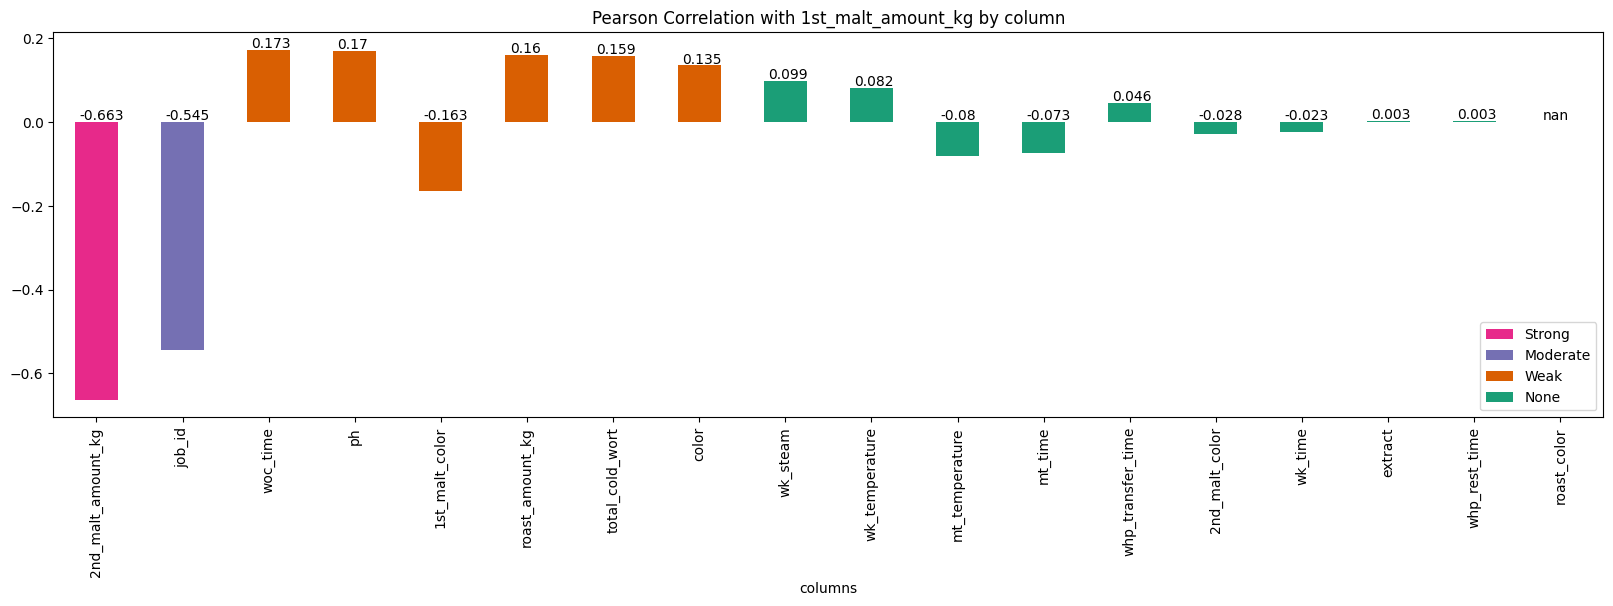

In [ ]:
plot_correlation_bars(df[selected_cols], '1st_malt_amount_kg', 'pearson')

##### insights:
total_cold_wort is highly correlated with:

    - extract
    - woc_time

wk_time and temperature are highly correlated with each other

1st and 2nd malt amount are highly correlated with each other

<Axes: title={'center': 'Spearman Correlation with 2nd_malt_color by column'}, xlabel='columns'>

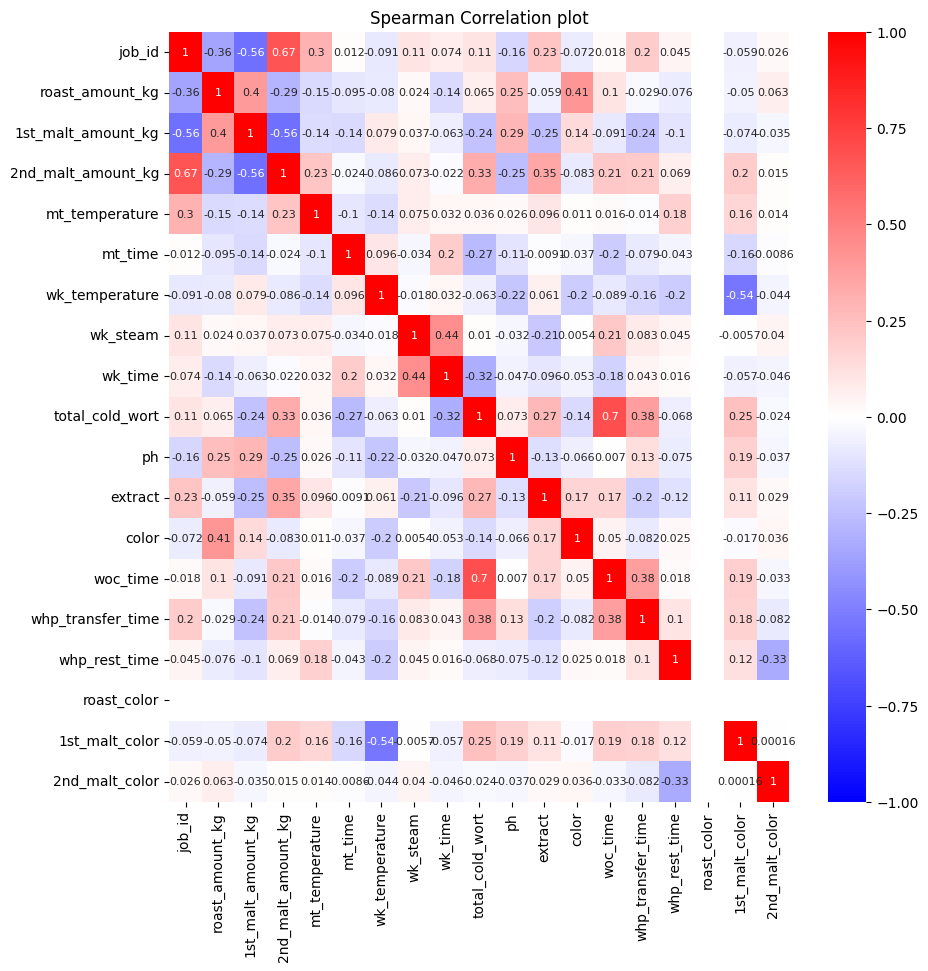

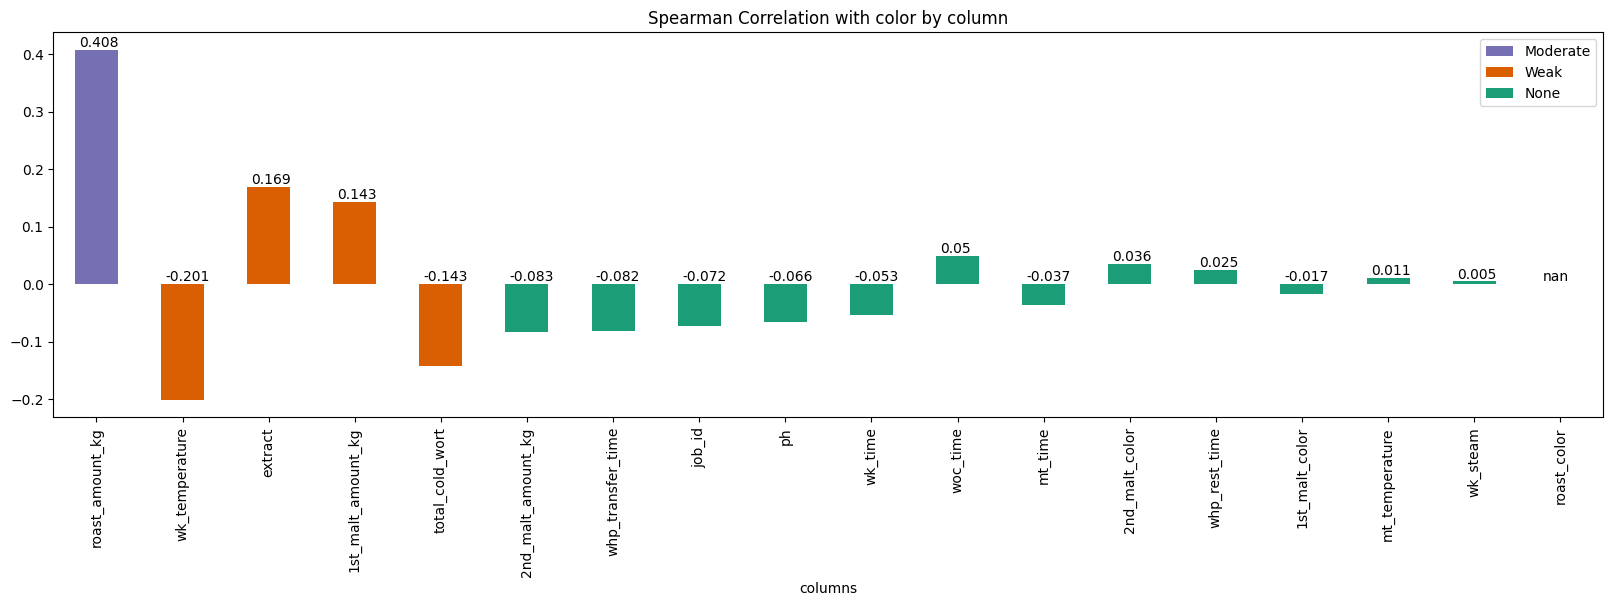

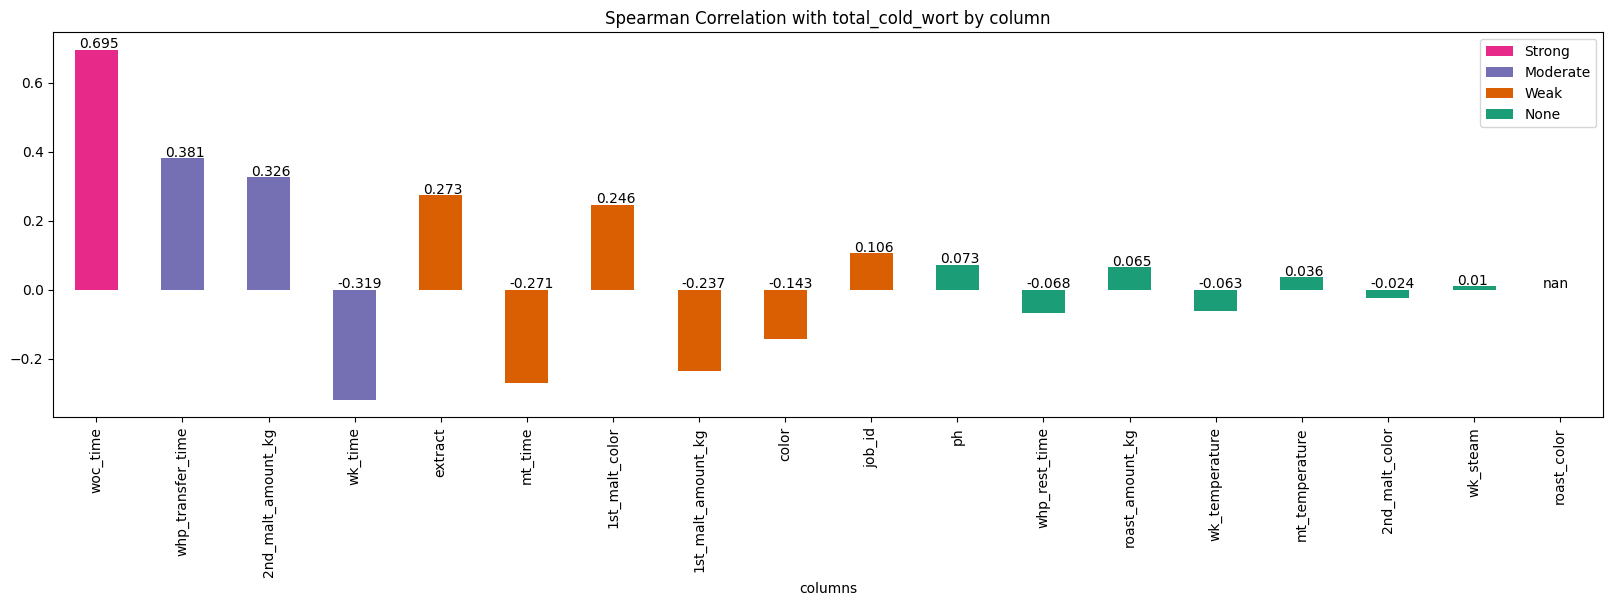

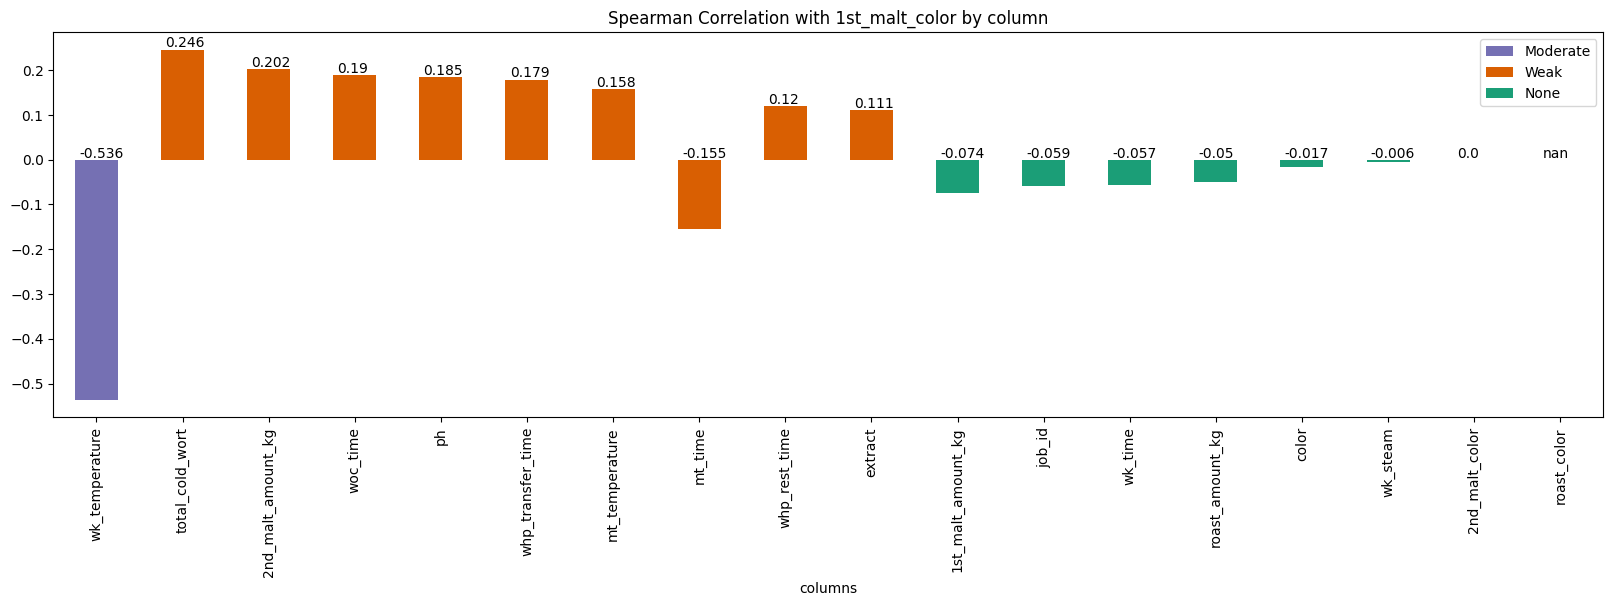

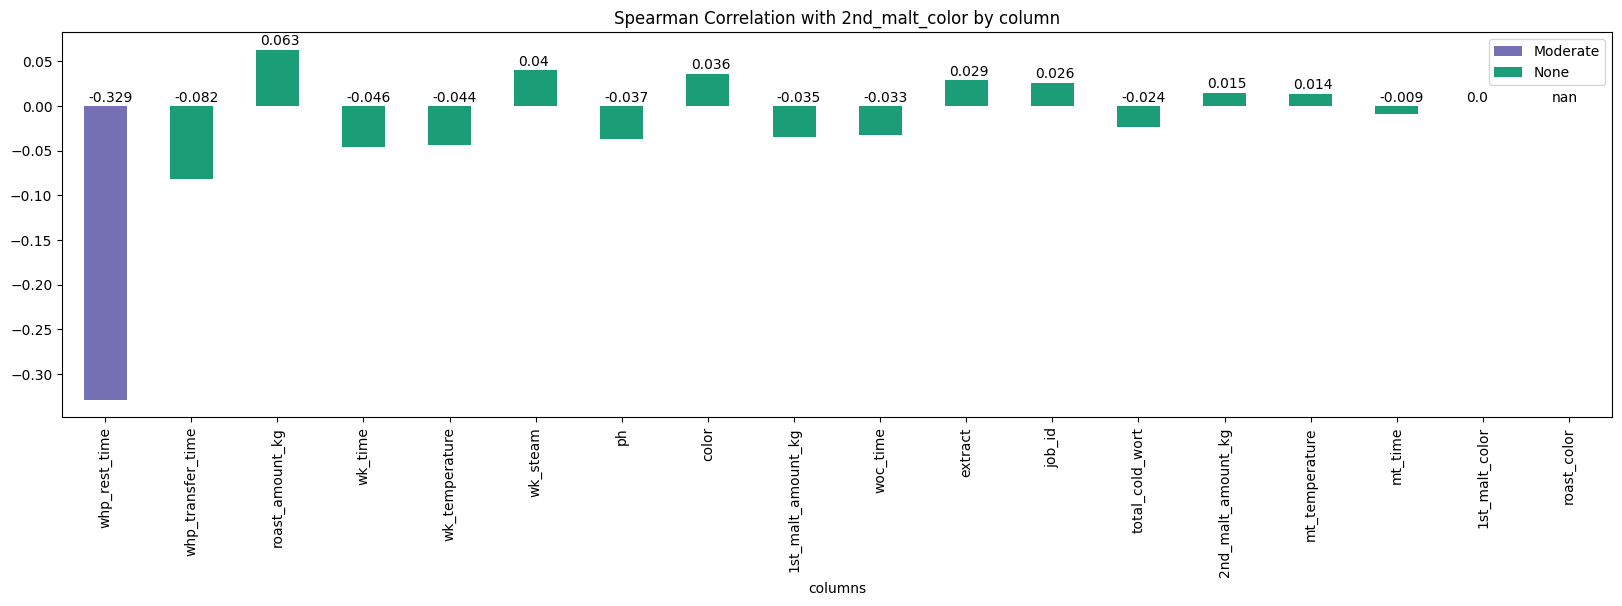

In [ ]:
plot_correlation_heatmap(df[selected_cols],  'spearman')
plot_correlation_bars(df[selected_cols], 'color', 'spearman')
plot_correlation_bars(df[selected_cols], 'total_cold_wort', 'spearman')
plot_correlation_bars(df[selected_cols], '1st_malt_color', 'spearman')
plot_correlation_bars(df[selected_cols], '2nd_malt_color', 'spearman')

##### Insights
total_cold_wort has many good correlations with:

    - woc_time
    - wk_time
    - whp_time
  
1st malt amount has good correlation with:

    - wk_temperature
    
2nd malt amount has good correlation with:

    - whp_rest_time

usar time_series_train_test_split

treinar com e sem outliers